# Coding project: Connect4 agent

SASSON Charlotte - BERARD Paul - PUJOL Corentin

## Introduction

The assignment is to develop an agent for Connect4, as implemented in the PettingZoo library, using Reinforcement Learning methods.

https://pettingzoo.farama.org/environments/classic/connect_four/

Students need to form groups of 2 or 3 *or 4* students, and will deliver a zip containing the code and a short report on the methods used. Deadline: April 14th.

The report should contain a description of the methods used and a description of the results. Here are a few questions that should be adressed in some way in the report
What design choices did you make in the development of your algorithm?
Describe the training procedure, the structure of the code.
Describe how you chose important hyperparameters, what you understand from their impact.
How did you assess the quality of your agent?
Do you think the approach you implemented would fare well on more complex environments, like backgammon, chess, go, Starcraft?
How would you improve it if given more time or computational power?
Describe also the workflow and how you split the work in the group.


The code should be clear and legible, variables well-named, and commented when helpful for comprehension. The final code should implement a class Player, with a method get_action that takes a state as specified in the PettingZoo environment and returns an integer between 0 and 6.

Performance is not the main point: better to show understanding of the methods you used and their limits.  

Ideas to get started: 
MCTS : https://sites.ualberta.ca/~szepesva/papers/CACM-MCTS.pdf

Eligibility Traces:
https://www.bkgm.com/articles/tesauro/tdl.html
https://www.ai.rug.nl/~mwiering/GROUP/ARTICLES/learning-chess.pdf

## Dependancies handling

In [1]:
# import pip 

# !pip install pettingzoo
# !pip install pygame
# !pip install numpy
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117


In [2]:
from pettingzoo.classic import connect_four_v3

import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Using the PettingZoo environment

This notebook provides smalls chunks of code to get you started with the Connect4 project. You do not have to use this code in you final file, but you can if you wish to. 

In [3]:
env = connect_four_v3.env(render_mode="rgb_array")

env.reset()

# The main difference with the standard gym api is the way the environment is queried. The `step` method return `None`. To get the data on the environment, use the `last` method
state, reward, terminated, truncated, info = env.last()

# state is a dictionary with two keys: observation and action_mask
print(
    state["observation"].shape
)  # Observation is a numpy array with three coordinates, indicating the positions of the pieces of of player 0 and 1 on the the board
print(state["observation"][:, :, 0])  # Where the pieces of player 0 are
print(state["observation"][:, :, 1])  # Where the pieces of player 1 are

print(state["action_mask"])  # an array showing whether the actions are legal or nots


(6, 7, 2)
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[1 1 1 1 1 1 1]


In [4]:
env.reset()
env.step(0)

state, reward, terminated, truncated, info = env.last()

print(
    state["observation"].shape
) 
print(state["observation"][:, :, 0])  
print(state["observation"][:, :, 1])  

print(state["action_mask"])

(6, 7, 2)
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[1 1 1 1 1 1 1]


# Agents

Here are some implementations of trivial agents that you should be able to beat ultimately. 

In [5]:
class RandomPlayer:
    def __init__(self, rng=None):
        if rng is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = rng

        self.name = "Random Player"

    def get_action(self, obs_mask, epsilon=None):
        return self.random_choice_with_mask(np.arange(7), obs_mask["action_mask"])

    def random_choice_with_mask(self, arr, mask):
        masked_arr = np.ma.masked_array(arr, mask=1 - mask)
        if masked_arr.count() == 0:
            return None
        return self.rng.choice(masked_arr.compressed())


In [6]:
class PlayLeftmostLegal:
    def __init__(self):
        self.name = "Left Player"

    def get_action(self, obs_mask, epsilon=None):
        for i, legal in enumerate(obs_mask["action_mask"]):
            if legal:
                return i
        return None


# Running a game


The following function runs a full game between the two agents. 

In [7]:
def play_game(env, agent0, agent1, display=False):
    done = False
    env.reset()
    obs, _, _, _, _ = env.last()
    while not done:
        for i, agent in enumerate([agent0, agent1]):
            action = agent.get_action(obs, epsilon=0)
            env.step(action)
            if display:
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()
            obs, reward, terminated, _, _ = env.last()
            done = terminated
            if np.sum(obs["action_mask"]) == 0:
                if display: 
                    print('Draw')
                return 0.5
            if done:
                if display:
                    print(f"Player {i}: {agent.name} won")
                    print(obs['observation'][:, :, 0]- obs['observation'][:, :, 1])
                return i

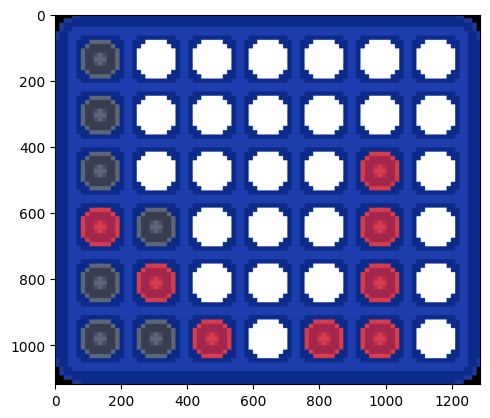

Player 0: Random Player won
[[-1  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0]
 [-1  0  0  0  0  1  0]
 [ 1 -1  0  0  0  1  0]
 [-1  1  0  0  0  1  0]
 [-1 -1  1  0  1  1  0]]


0

In [8]:
agent0 = RandomPlayer()
agent1 = PlayLeftmostLegal()

play_game(env, agent0, agent1, display=True)

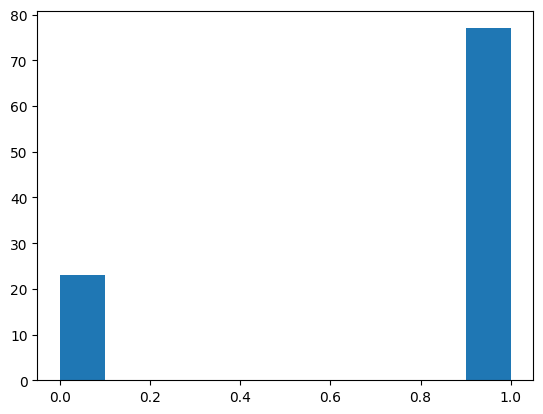

In [9]:
plt.hist([play_game(env, agent0, agent1, display=False) for _ in range(100)])
plt.show()

# Emulating a Gym environment

If we fix the opposite policy, the game from the point of view of the agent is equivalent to a Gym environment. The following class implements this simulation. Then any algorithm that would work in a gym environment with the same observations will work here. 

Note that we implemented the possibility to be the first or the second player. 

In [10]:
class EnvAgainstPolicy: 
    def __init__(self, env, policy, first_player=True):
        self.policy = policy
        self.env = env
        self.first_player = first_player
        self.reset()

    def step(self, action):
        self.env.step(action)
        obs, reward, terminated, _, _ = self.env.last()
        if terminated: 
            self.last_step = obs, reward, True, False, {}
        else: 
            action = self.policy.get_action(obs)
            self.env.step(action)
            obs, reward, terminated, _, _ = self.env.last()
            self.last_step = obs, -reward, terminated, False, {}
        return self.last_step

    def reset(self):
        self.env.reset()
        if not(self.first_player): 
            obs, _, _, _, _ = self.env.last()
            action = self.policy.get_action(obs)
            self.env.step(action)

        self.last_step = self.env.last()
        return self.last_step

    def last(self):
        return self.last_step

# Evaluating an agent against a fixed policy: 

Using the environment above, we can evaluate the agent against this fixed policy. 

In [11]:
def eval_against_policy(env, agent, policy, N_episodes=10, first_player=True):
    eval_env = EnvAgainstPolicy(env, policy, first_player=first_player)
    results = []
    for _ in range(N_episodes):
        done = False
        eval_env.reset()
        obs, _, _, _, _ = eval_env.last()
        while not done:
            action = agent.get_action(obs, epsilon=0)
            eval_env.step(action)
            obs, reward, done, _, _ = eval_env.last()
        results.append(reward)
    return results

We can see that if both players play randomly, there is a small but significant advantage to the first player. 

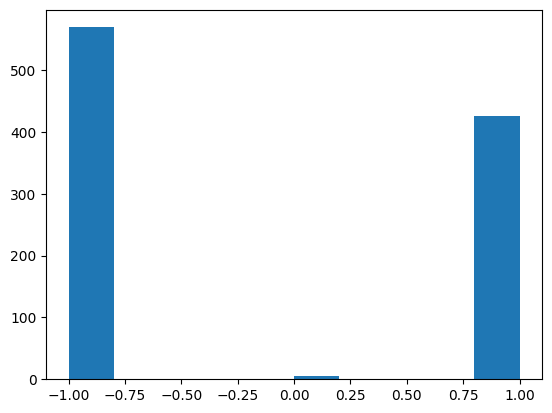

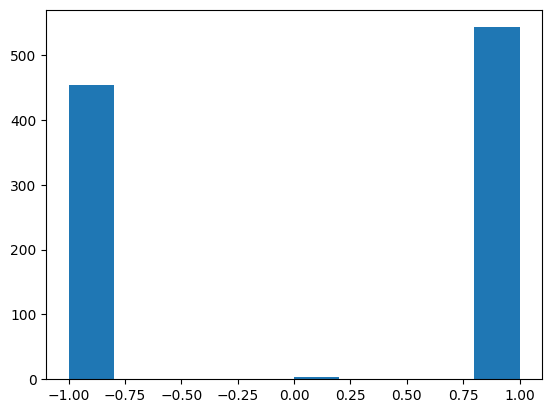

In [12]:
plt.hist(eval_against_policy(env, RandomPlayer(), RandomPlayer(), N_episodes=1000, first_player=False))
plt.show()
plt.hist(eval_against_policy(env, RandomPlayer(), RandomPlayer(), N_episodes=1000, first_player=True))
plt.show()

# Your turn 

Try to build a decent agent. Be creative! You can try any idea that you have: the grade is not about performance of the agent, but more about illustrating phenomena happening in Reinforcement Learning for turn-based games. It's okay to 'help' the agent in any way, as long as it follows the ideas of RL (i.e., as long as there is some learning involved).




## Technical choices

To train our agent in Connect4, we chose to implement a Q-Learning algorithm.

How the Q-learning algorithm works:

The Q-learning algorithm is a reinforcement method that allows an agent to learn to make decisions based on the expected value of future rewards.

For each possible state of the game, the agent maintains a table Q(s, a) of expected utility values for each possible action a, assuming that the agent follows an optimal policy.

The agent chooses an action based on the current state of the game, selecting the action that maximises the expected value of future rewards.

The agent updates the value of Q(s, a) according to the actual reward it receives for this action and the value of Q(s+1, a+1) for the next state and action, using the Q-learning update formula:

Q(s, a) <- Q(s, a) + alpha * (r + gamma * max(Q(s+1, a+1)) - Q(s, a))

With alpha the learning rate, gamma the discount rate (which prioritises immediate rather than future rewards), r is the actual reward for the action taken, and max(Q(s+1, a+1)) is the maximum expected value of future rewards for the next state s+1 and all possible actions a+1.

## Initialization of parameters

In [13]:
# EPISODES = 10000
# EPSILON = 0.1
# ALPHA = 0.2
# GAMMA = 0.9

## Initialization of the Q table

Table Q will contain the action-state values for each state and each possible action. In this case, there are 2^42 possible states (2 for each grid cell) and 7 possible actions (one for each grid column):

In [14]:
# Q = np.zeros((2**42, 7), dtype='uint8')

## Training the agent in the environment

Training the agent by running episodes in the Connect Four environment.

In [15]:
# """
# Création d'une instance de l'environnement Connect Four V3 de PettingZoo. 

# Cet environnement a deux agents, chacun jouant un pion différent.
# Le but est d'aligner quatre pions de la même couleur sur une grille de 6x7 cases.
# """
# env = connect_four_v3.env()

# for i in range(EPISODES): #Un épisode correspond à une itération d'entraînement de l'agent (Il s'agit d'une partie complète)
#     obs = env.reset() #On réinitialise l'environnement pour que l'agent à chaque itération apprenne à jouer d'un état initial de la grille
#     done = False #Condition de sortie de la boucle (lorsque la partie est terminée)
#     while not done:
        
#         """
#         Choix d'une action basée sur la politique epsilon-greedy
        
#         Si le nombre aléatoire généré est inférieur à epsilon :
#              - l'agent choisit une action aléatoire parmi les actions possibles

#         Sinon :
#             - il choisit l'action qui maximise la valeur Q de l'état actuel.
#         """
        
#         if np.random.uniform() < EPSILON: 
#             action = np.random.choice(env.action_spaces["player_0"])
#         else:
#             state = np.ravel_multi_index((obs['board'], obs['mark']), (2, 3) * (6,))
#             action = np.argmax(Q[state])
            
#         #L'environnement effectue ensuite l'action choisie par l'agent et renvoie la nouvelle observation, la récompense, si l'épisode est terminé et des informations supplémentaires.
#         new_obs, reward, done, _ = env.step(action)
#         new_state = np.ravel_multi_index((new_obs['board'], new_obs['mark']), (2, 3) * (6,))
        
#         # Update Q-table
#         Q[state, action] += ALPHA * (reward + GAMMA * np.max(Q[new_state]) - Q[state, action])
#         # Update state
#         obs = new_obs

We then realised that it was not possible to use Q-Learning to solve this problem as there are too many states in Connect4... A method approximating the Q-function would be better able to meet our need. 

Indeed, it would consist in approximating the Q-value function by a parametric function learned by the agent.

To do this we will first implement a Deep Q-Network (DQN). This is an extension of Q-Learning that uses a neural network to approximate the Q-function. DQNs are particularly effective for tasks that have complex state spaces and discrete actions.

## DQN

We start by setting up the architecture of the neural network used to approximate the Q function. 

The network architecture is composed of three fully connected layers of different sizes. The first two layers each have 128 neurons and use a ReLU activation function to introduce non-linearity into the network. The last layer has no activation function and directly returns the Q-values for the different actions.

The model uses the Adam optimisation algorithm for updating the network weights during training.

In [16]:
class DQN(nn.Module):
    """
    Classe implémentant un réseau de neurones profond pour approximer la fonction Q d'un environnement de RL
    Paramètres :
        input_shape (tuple) : la forme de l'entrée du réseau de neurones, spécifie la taille de l'état de l'environnement
        num_actions (int) : le nombre d'actions disponibles dans l'environnement
        lr (float) : le taux d'apprentissage utilisé pour optimiser les poids du réseau de neurones
    """
    def __init__(self, input_shape, num_actions, lr):
        super().__init__()
        self.fc1 = nn.Linear(input_shape[0], 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
class DQNAgent:

    """
    A DQNAgent represents an agent that uses a Deep Q-Network (DQN) to approximate the Q-function of a given environment.

    Args:
        observation_shape (tuple): The shape of the observation space of the environment.
        action_space (gym.Space): The action space of the environment.
        lr (float): The learning rate used for the optimizer.
        gamma (float): The discount factor used in the Q-learning update.
        buffer_size (int): The maximum size of the replay buffer.
        batch_size (int): The batch size used for each training step.
        target_update_frequency (int): The number of steps between each update of the target network.
        epsilon_start (float): The starting value of epsilon for epsilon-greedy exploration.
        epsilon_end (float): The final value of epsilon for epsilon-greedy exploration.
        epsilon_decay_steps (int): The number of steps over which to linearly decay epsilon from its starting value to its final value.
        device (str): The device used for training the neural network ('cpu' or 'cuda').
    """
    def __init__(self, env, net, replay_buffer, batch_size, gamma, epsilon_start, epsilon_end, epsilon_decay):
        self.env = env
        self.net = net
        self.replay_buffer = replay_buffer
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.epsilon = epsilon_start

    def get_action(self, state):
        # Choix aléatoire d'une action avec une probabilité epsilon
        if np.random.rand() < self.epsilon:
            action = self.env.action_space.sample()

        # Exploitation de la Q-function apprise pour choisir l'action maximisant la Q-value
        else:
            state_tensor = torch.tensor([state], dtype=torch.float32) # Conversion de l'état en tensor pour l'alimenter dans le réseau de neurones
            q_values = self.net(state_tensor).detach().numpy() # Prédiction des Q-values de chaque action pour l'état donné
            action = np.argmax(q_values) # Sélection de l'action maximisant la Q-value prédite
        
        return action

    # def train(self):